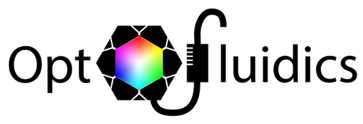

# Optofluidics Template
This Jupyter Notebook is a template for using the Optofluidics module to process HDF5 spectroscopic data.

In [1]:
import optofluidics as of
from lmfit import Parameters
import matplotlib.pyplot as plt

# Set file path to datafile location, including the .h5 file extension.
file_path = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\Measurements\Carbon Dots - Absorption\Jupyter Temp\2019-11-06-alt.h5'

# Set save path to the desired export location.
export_path = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\Measurements\Carbon Dots - Absorption\Exports'

## Load Datafile
Load the desired datafile and list the datasets contained within.

In [2]:
# Load the datafile and create a Datafile instance
df1=of.Datafile(file_path)

# List the datasets contained within the datafile
df1.list_groups()

Datafile intialised successfully 

Key 0: aCD(OLD)-MV-EDTA-Quick1 

Key 1: aCD(OLD)-MV-EDTA-Quick2 



## Pre-Processing
Create a Dataset instance, pre-process the data to calculate elapsed time and background correct, then calculate the absorbances using the stored reference spectra.

In [12]:
# Create a Dataset instance (default is key 0 and timelapse 0 for the datafile specified)
ds1=of.Dataset(df1,1,0)

# Pre-process the data and calculate the absorbances
ds1.pre_process()
ds1.calculate_abs()

/aCD(OLD)-MV-EDTA-Quick2/timelapse_0 dataset loaded successfully 

Measurement was started at 2019-11-07 00:03:01.641000, 
 normalising times and applying a background correction 

Measurement contains 3396 spectra with 1044 wavelengths 

Elapsed time for pre-processing: 6.827225900000002


C:\Users\tl457\OneDrive - University Of Cambridge 1\Optofluidics Python Package\optofluidics\pre_proc.py:235: RuntimeWarning: divide by zero encountered in log10
  abs=-np.log10(self.pre_proc_data.div(self.ref_spectra_arr))
C:\Users\tl457\OneDrive - University Of Cambridge 1\Optofluidics Python Package\optofluidics\pre_proc.py:235: RuntimeWarning: invalid value encountered in log10
  abs=-np.log10(self.pre_proc_data.div(self.ref_spectra_arr))


,191.525217,192.321910,193.118546,193.915127,194.711650,195.508118,196.304528,197.100882,197.897180,198.693421,...,979.760213,980.482831,981.205362,981.927806,982.650163,983.372433,984.094617,984.816713,985.538722,986.260644
0.000,0.176091,NaN,0.477121,-0.000000,-0.032185,-0.062148,-0.000000,-0.032185,0.124939,-0.062148,...,0.204120,0.032185,-0.062148,0.062148,0.028029,0.079181,NaN,0.176091,0.176091,0.176091
0.776,0.477121,inf,0.477121,inf,-0.116506,-0.000000,-0.029963,-0.000000,-0.000000,-0.000000,...,-0.026329,-0.029963,-0.000000,-0.000000,0.028029,0.079181,-inf,-0.000000,-0.000000,-0.000000
1.551,NaN,inf,-0.124939,0.301030,-0.141329,-0.032185,0.104735,0.034762,0.028029,-0.062148,...,-0.000000,-0.029963,0.034762,0.029963,0.057992,-0.000000,NaN,-0.000000,-0.000000,-0.000000
2.324,0.477121,inf,inf,-0.000000,-0.090177,-0.032185,-0.029963,0.034762,0.124939,-0.062148,...,-0.000000,0.104735,-0.062148,0.029963,-0.026329,0.051153,-inf,0.176091,0.176091,0.176091
3.101,0.477121,NaN,0.477121,0.301030,-0.000000,-0.000000,-0.000000,0.072551,0.057992,-0.062148,...,0.028029,-0.057992,0.034762,-0.000000,-0.000000,0.051153,NaN,0.477121,0.477121,0.477121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635.410,0.477121,inf,-0.124939,-0.176091,-0.090177,-0.062148,0.032185,-0.062148,0.028029,-0.090177,...,-0.000000,-0.029963,-0.032185,-0.054358,-0.026329,0.051153,-inf,0.176091,0.176091,0.176091
2636.178,NaN,-0.30103,NaN,-0.000000,-0.116506,0.072551,-0.000000,0.034762,0.057992,-0.090177,...,0.057992,0.032185,-0.032185,-0.000000,0.028029,0.079181,NaN,-0.124939,-0.124939,-0.124939
2636.953,0.477121,-0.00000,0.176091,-0.000000,-0.090177,0.072551,-0.029963,0.034762,0.057992,-0.062148,...,-0.026329,-0.109144,0.034762,0.029963,-0.026329,0.024824,NaN,-0.000000,-0.000000,-0.000000
2637.727,0.477121,NaN,0.176091,-0.000000,-0.062148,-0.062148,-0.000000,0.159701,0.124939,-0.032185,...,0.057992,0.032185,-0.032185,-0.028029,-0.074634,0.051153,NaN,0.477121,0.477121,0.477121


## Processing
Plot colourmap, calculate concentrations and apply a drift correction

Will plot 599.8 nm in dataset
Will plot 1000.0 s in dataset


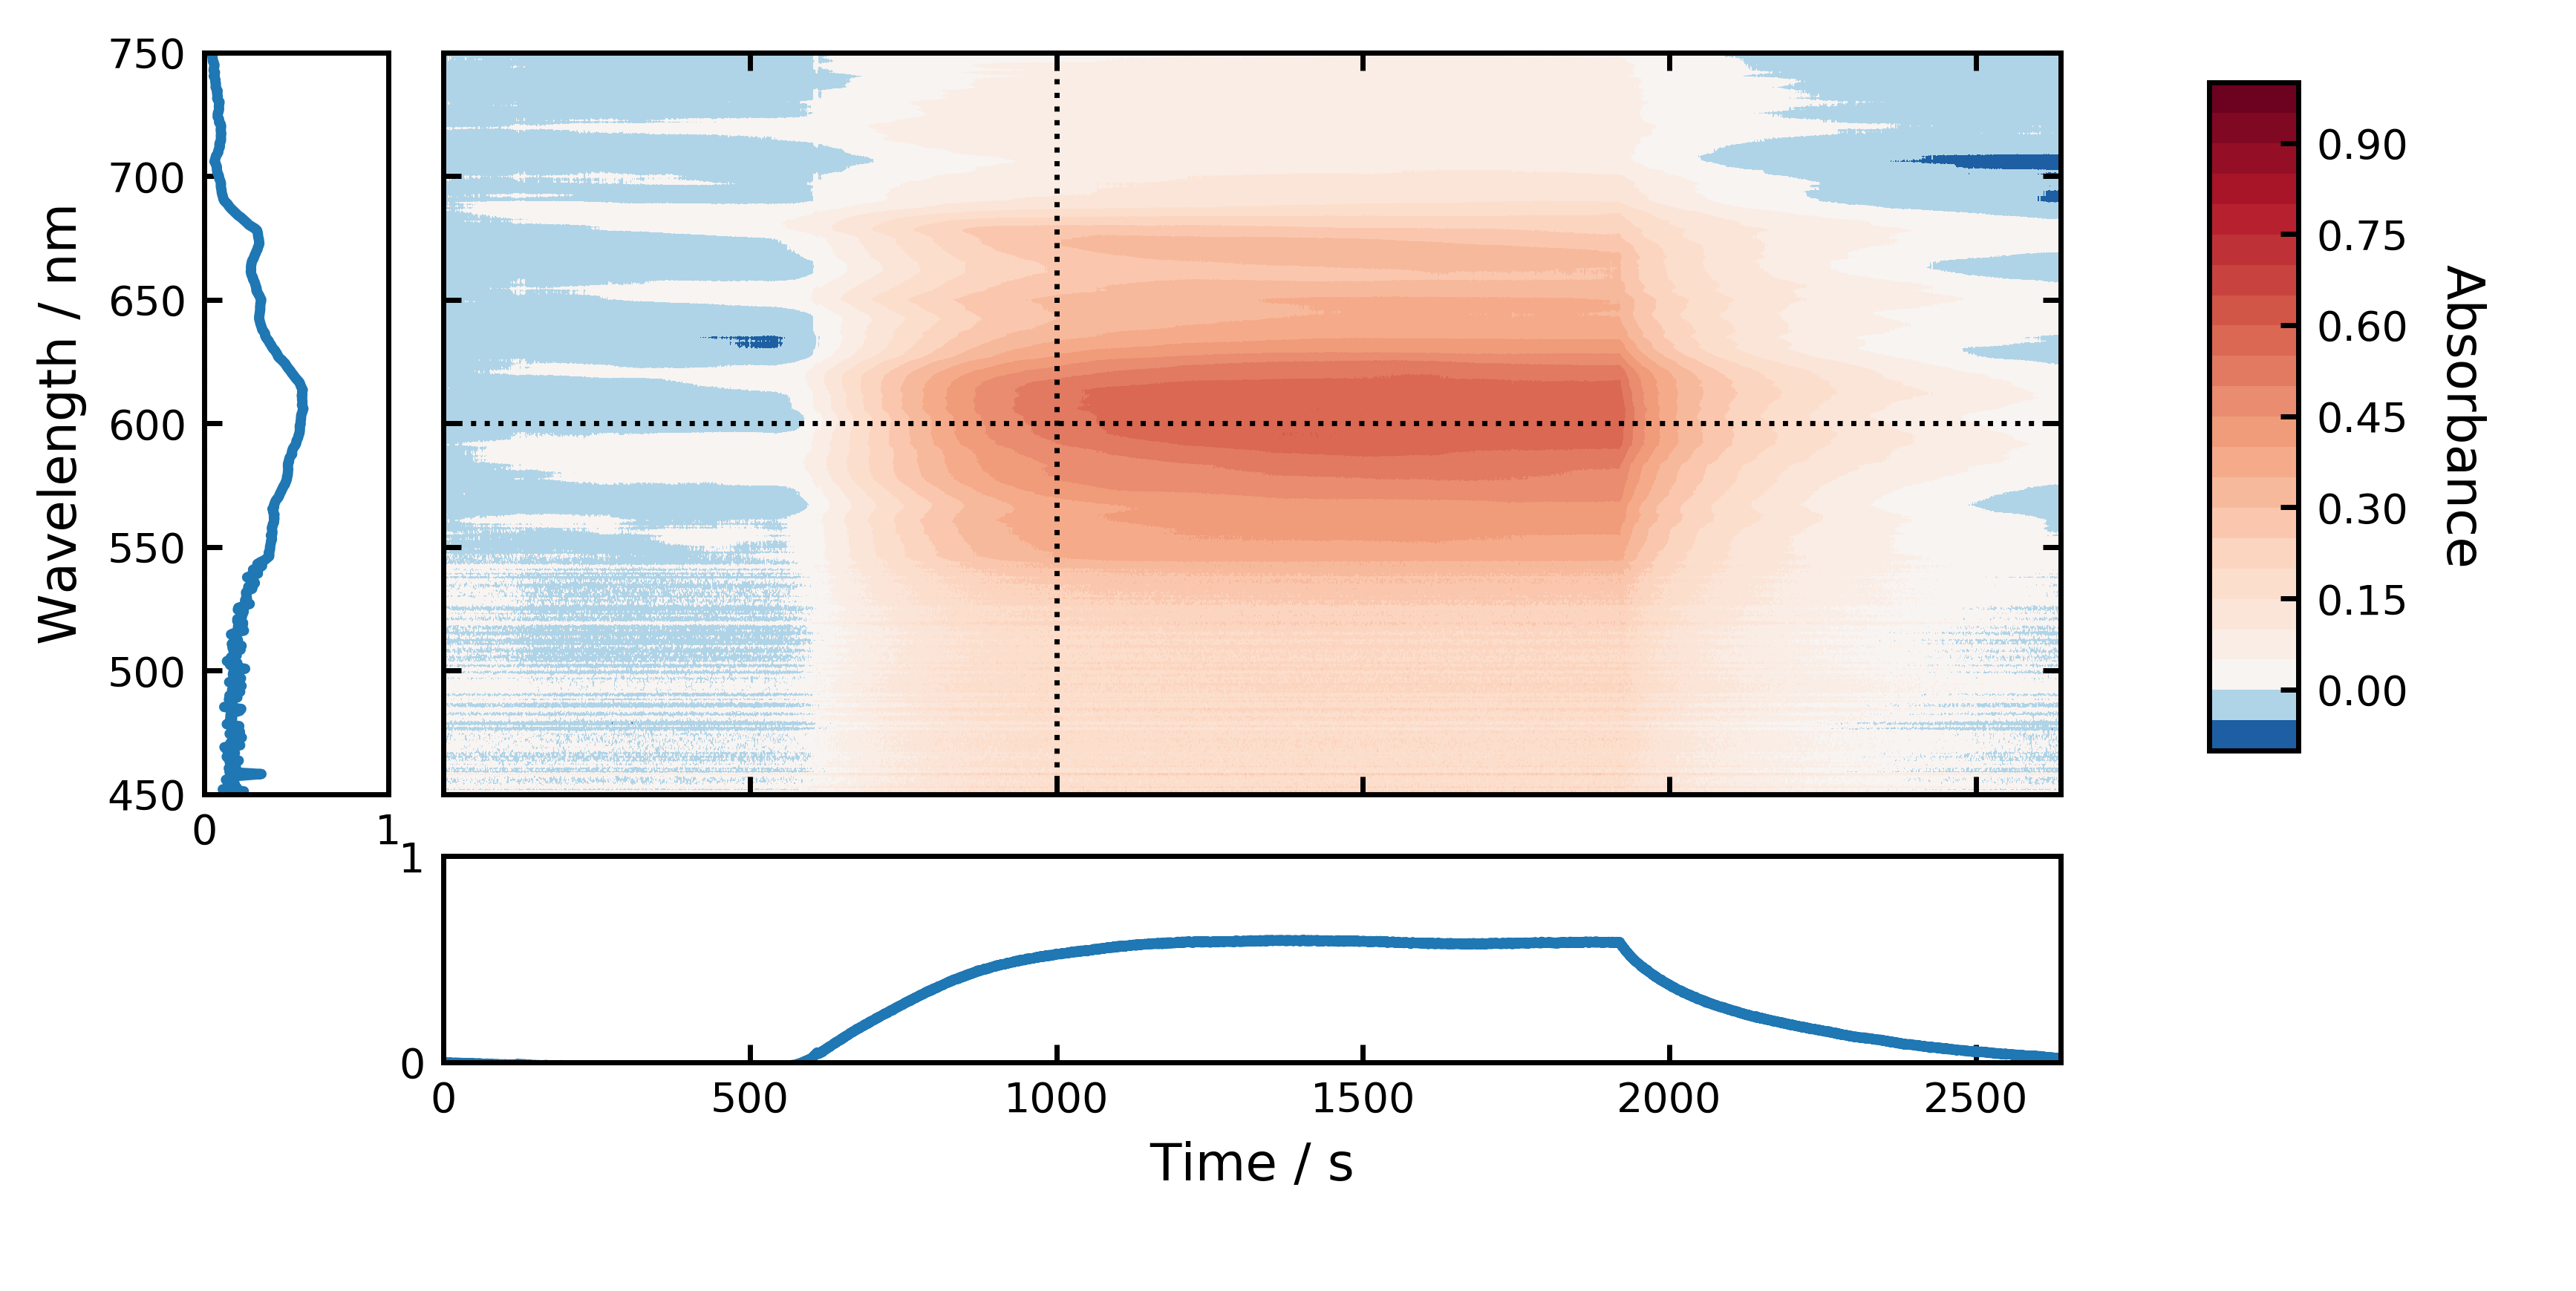

In [13]:
# Plot colourmap
of.colourplot(ds1,[1000],[600],-0.1,1)

Calculating concentration using range 597.50551777423 nm to 602.8476550090985 nm.
Absorbance will be averaged over 8 data points


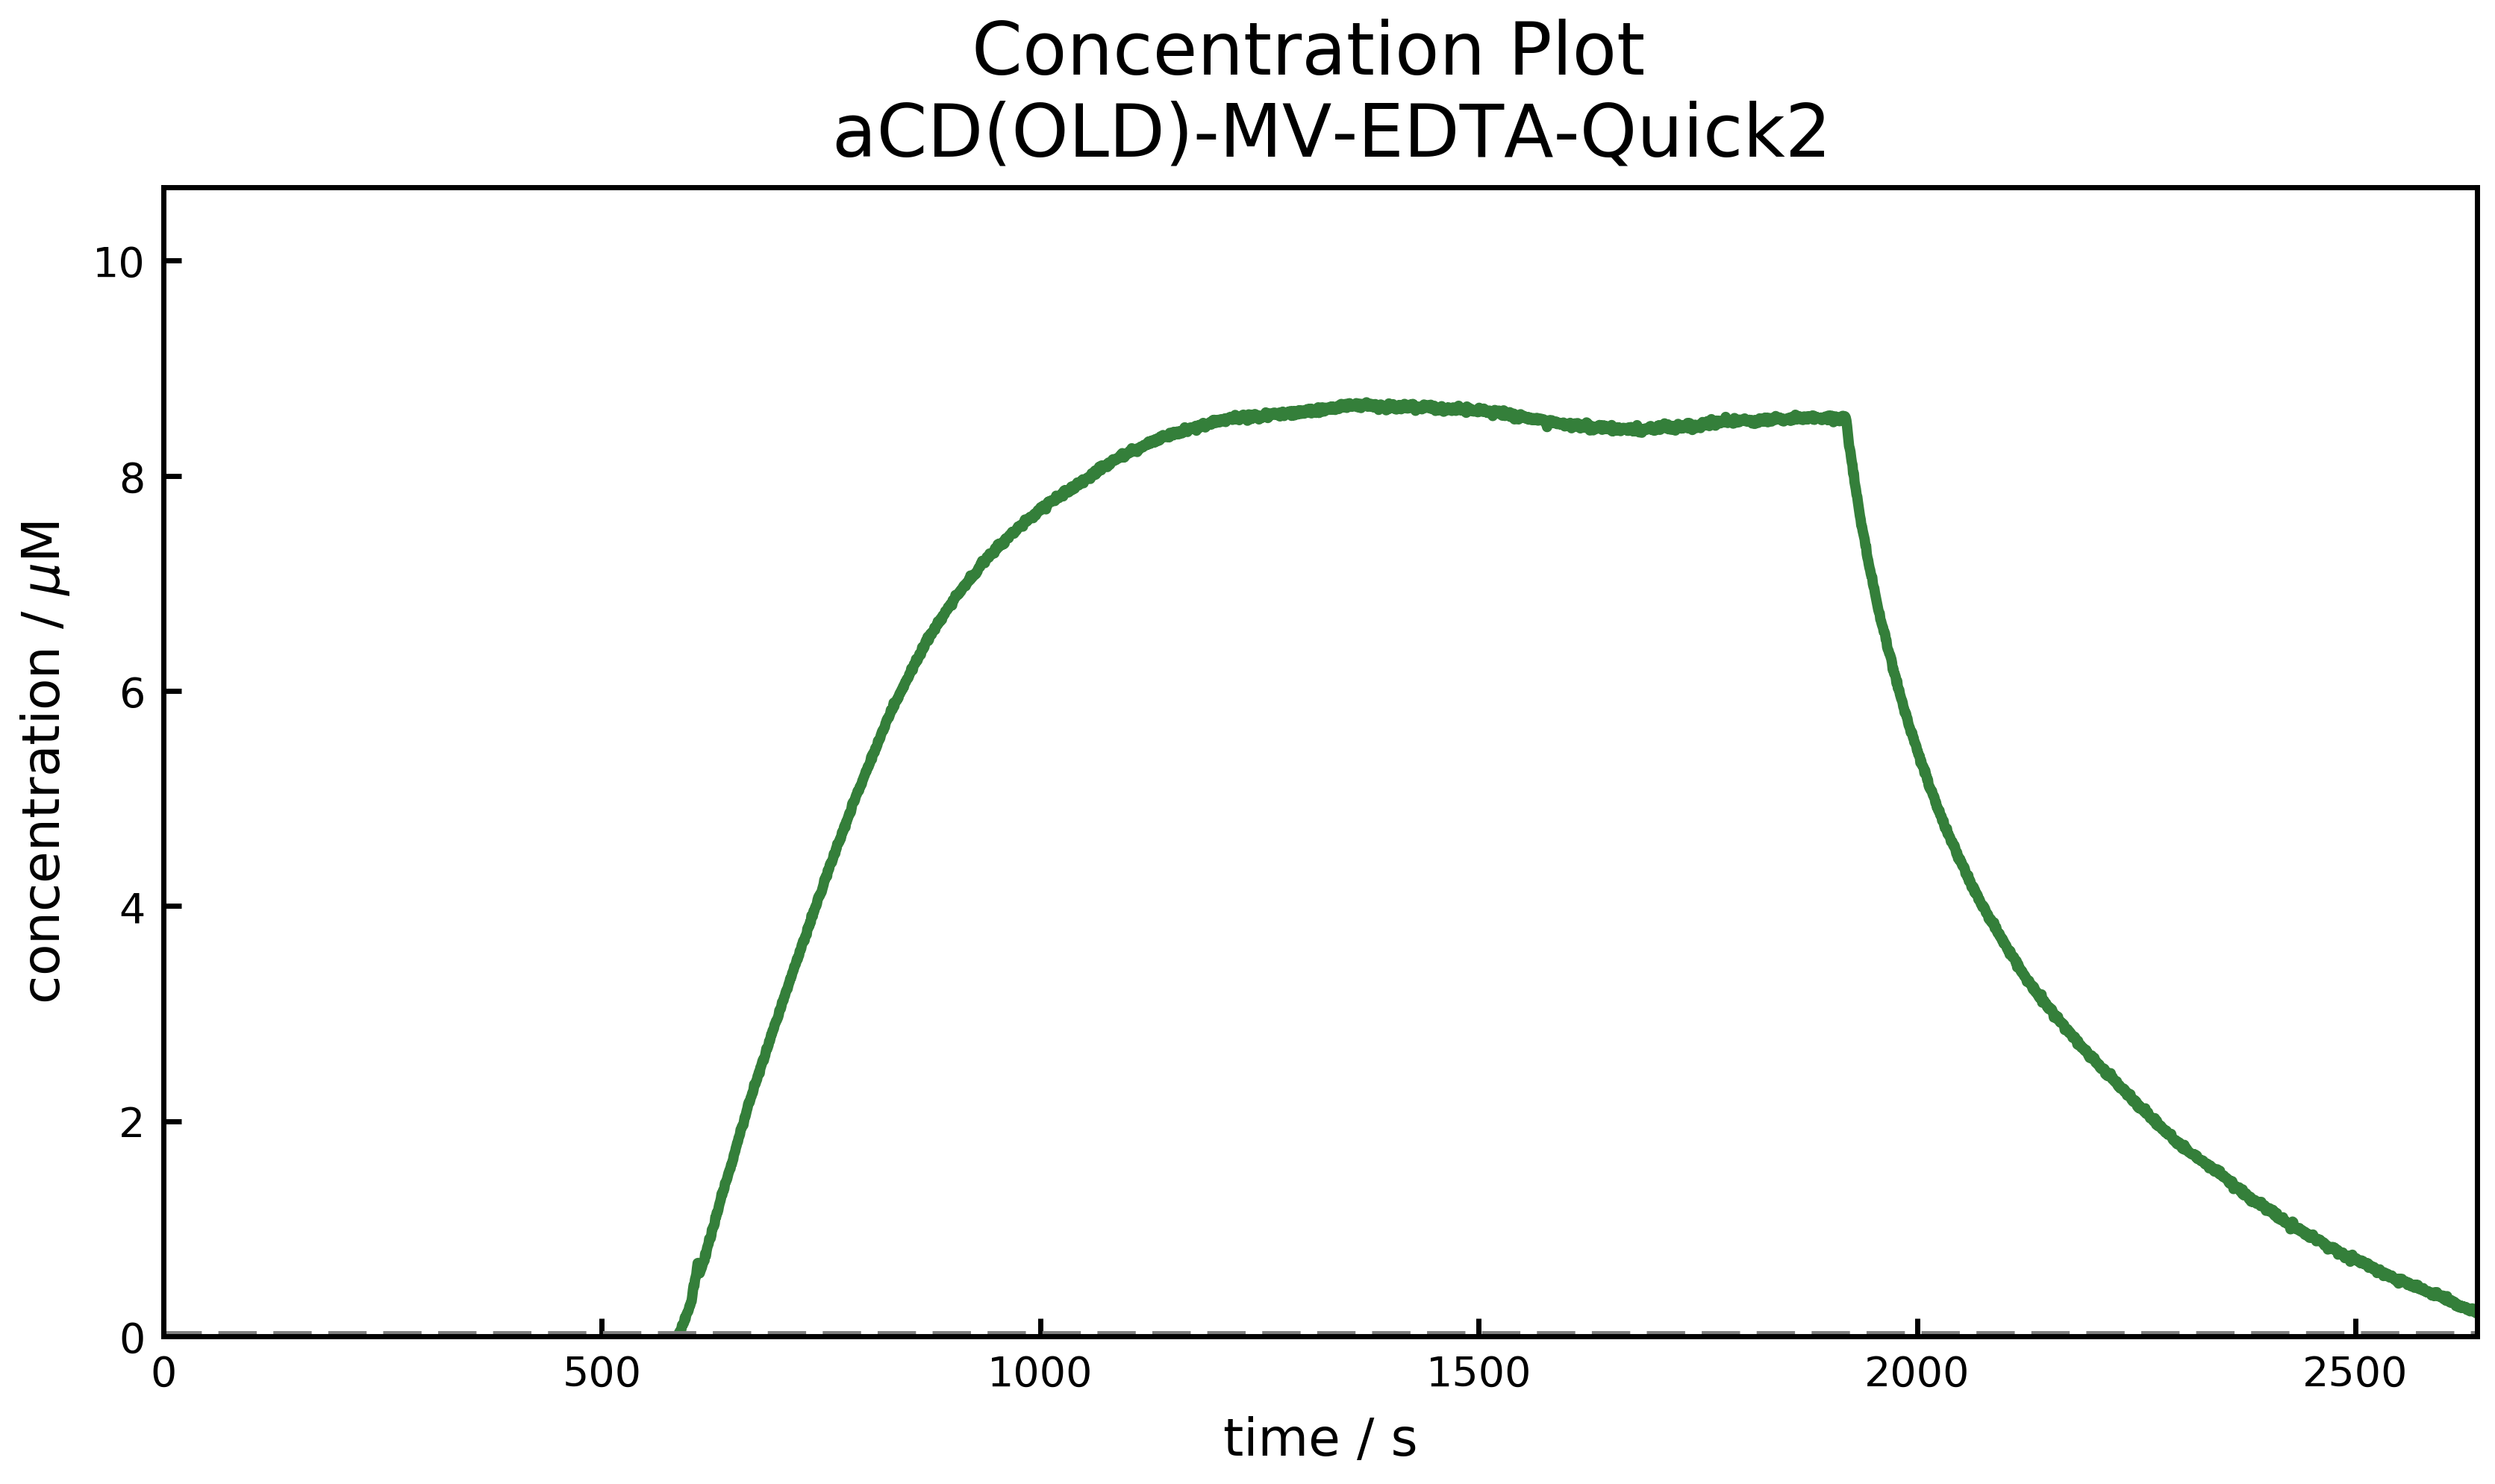

In [14]:
# Create Reaction instance
c1=of.Reaction(ds1,600,13600,5)

# Calculate concentrations
c1.calculate_conc(5)

# Apply a linear drift correction
#c1.linear_drift([2790,5750,8650])

# Plot the concentration profile
c1.plot_conc()

1.0 cycles detected


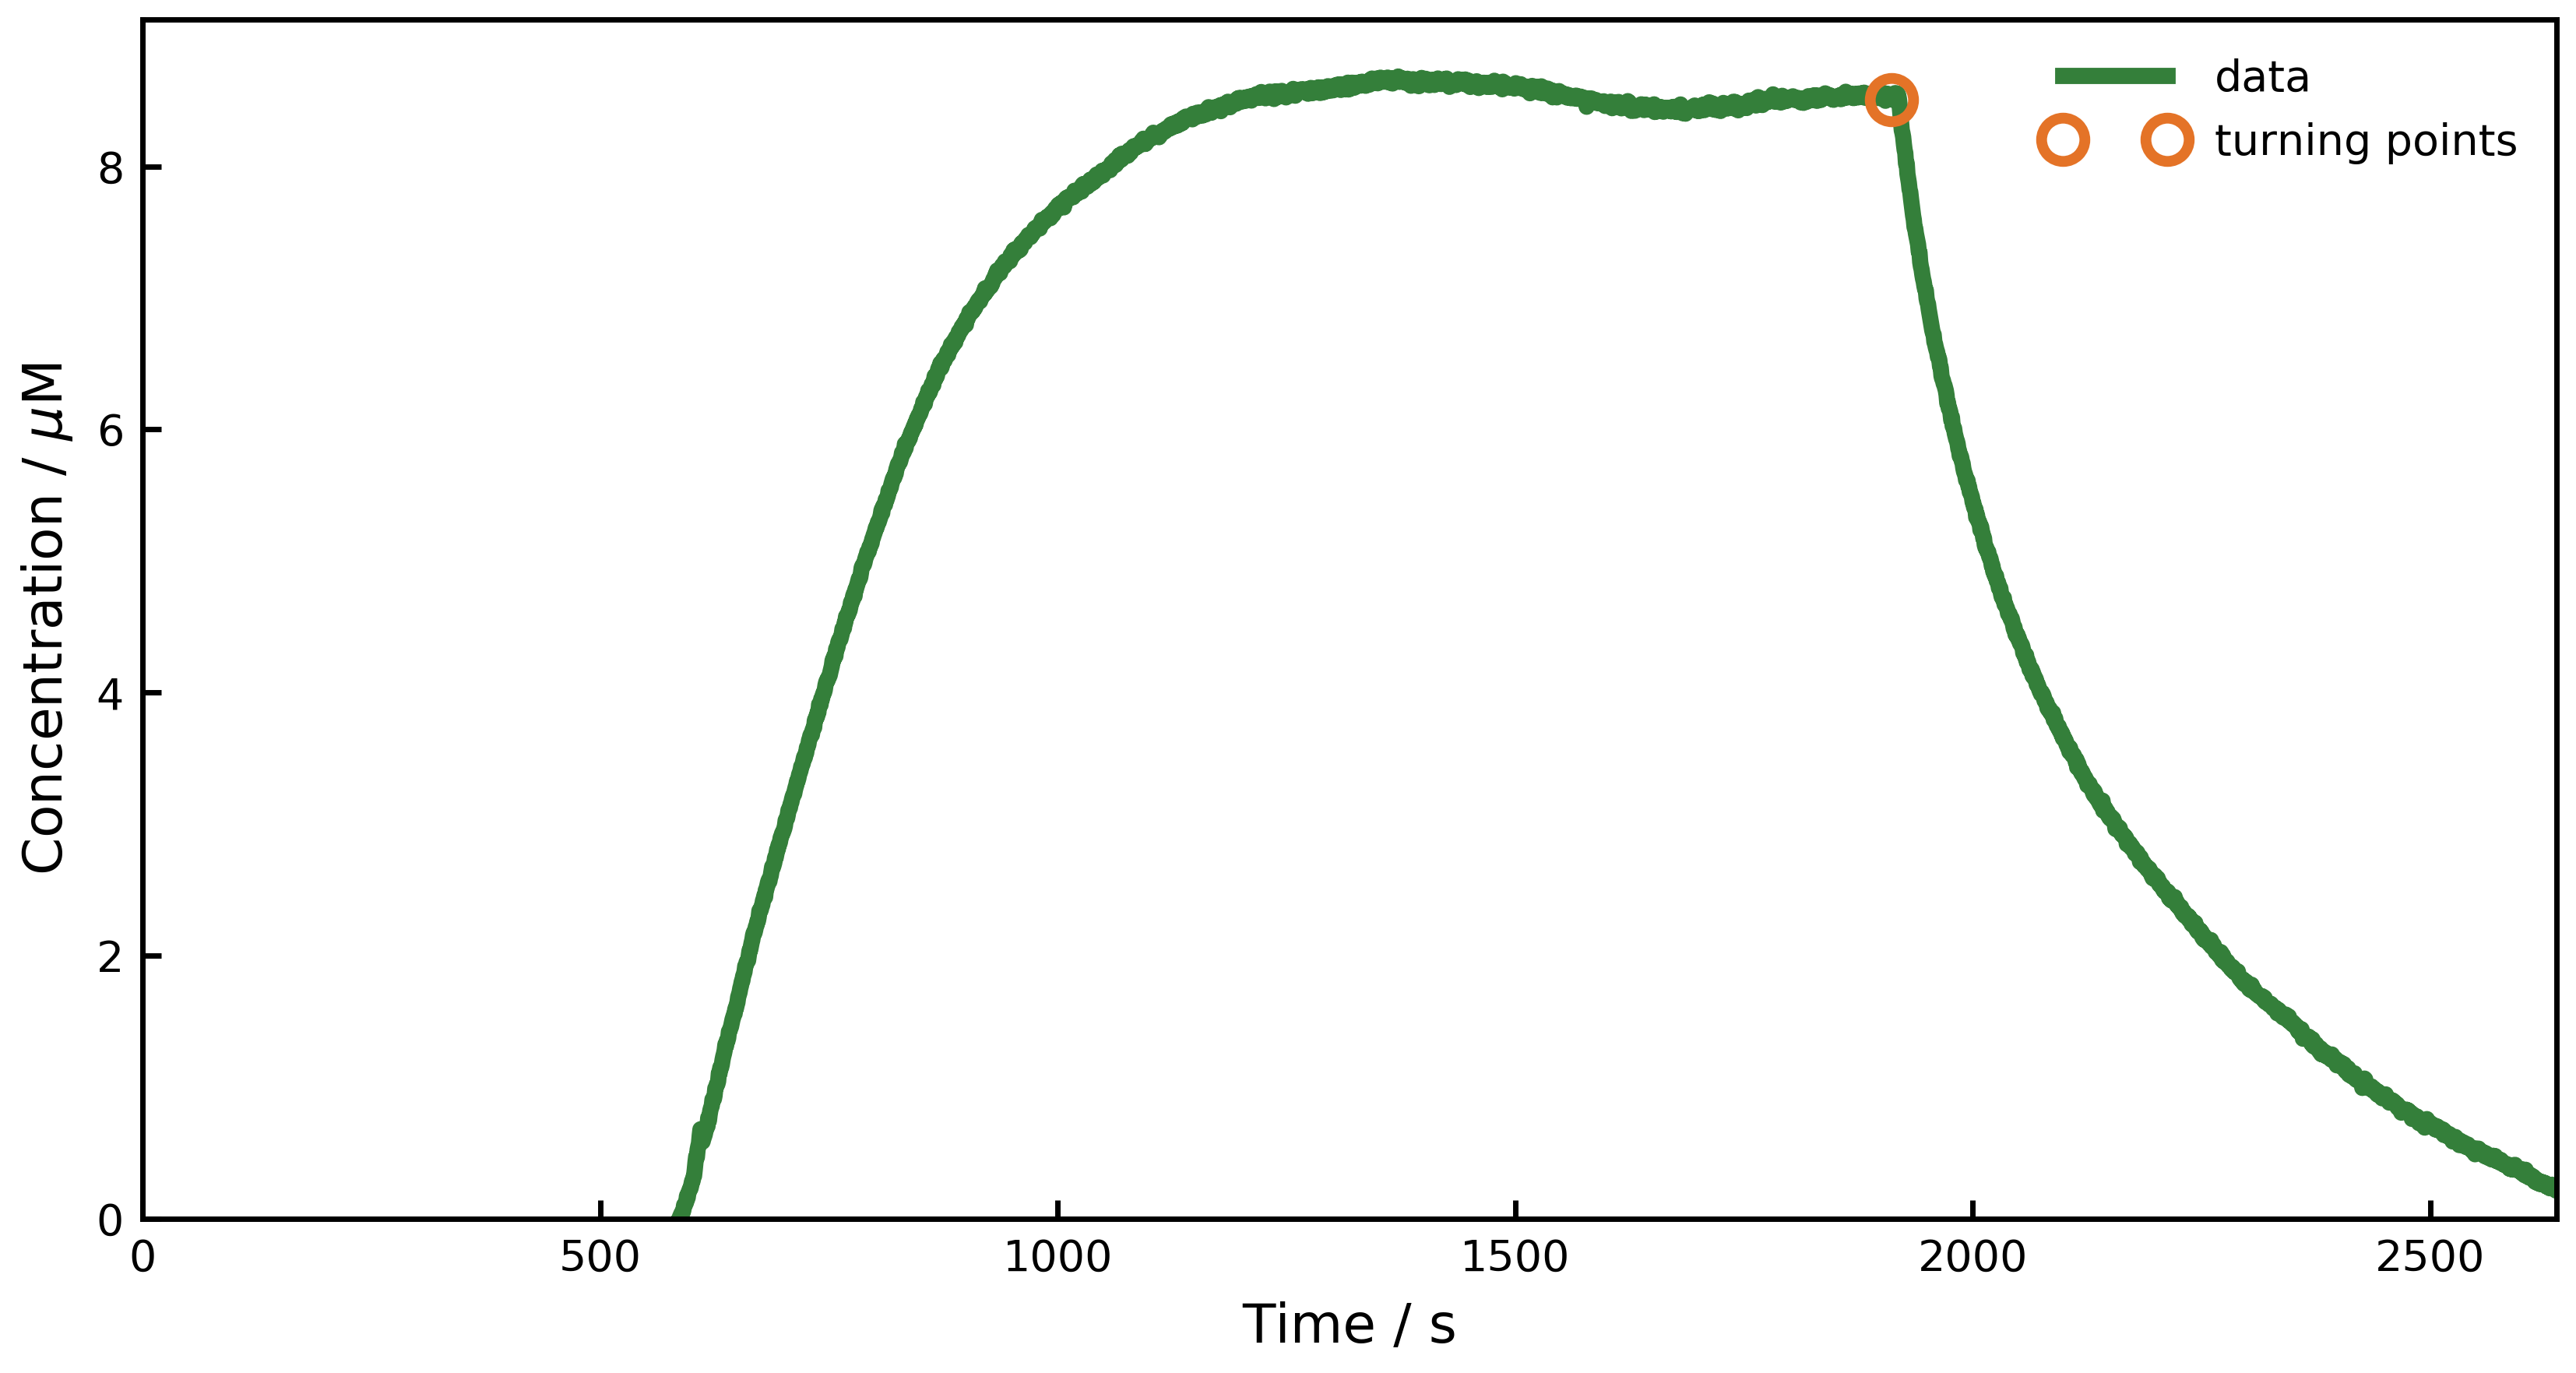

[ 182 1911]


In [19]:
# Find turning points to automatically detect the UV on/off times
# Ignore the first turning point in the plot as we manually specify in the find_turn_points function

times_arr=c1.find_turn_points(182,0.022,translate=60,plot=True)
print(c1.turning_points)

## Modelling
Create an initial model then run a fitting algorithm to find the best parameters

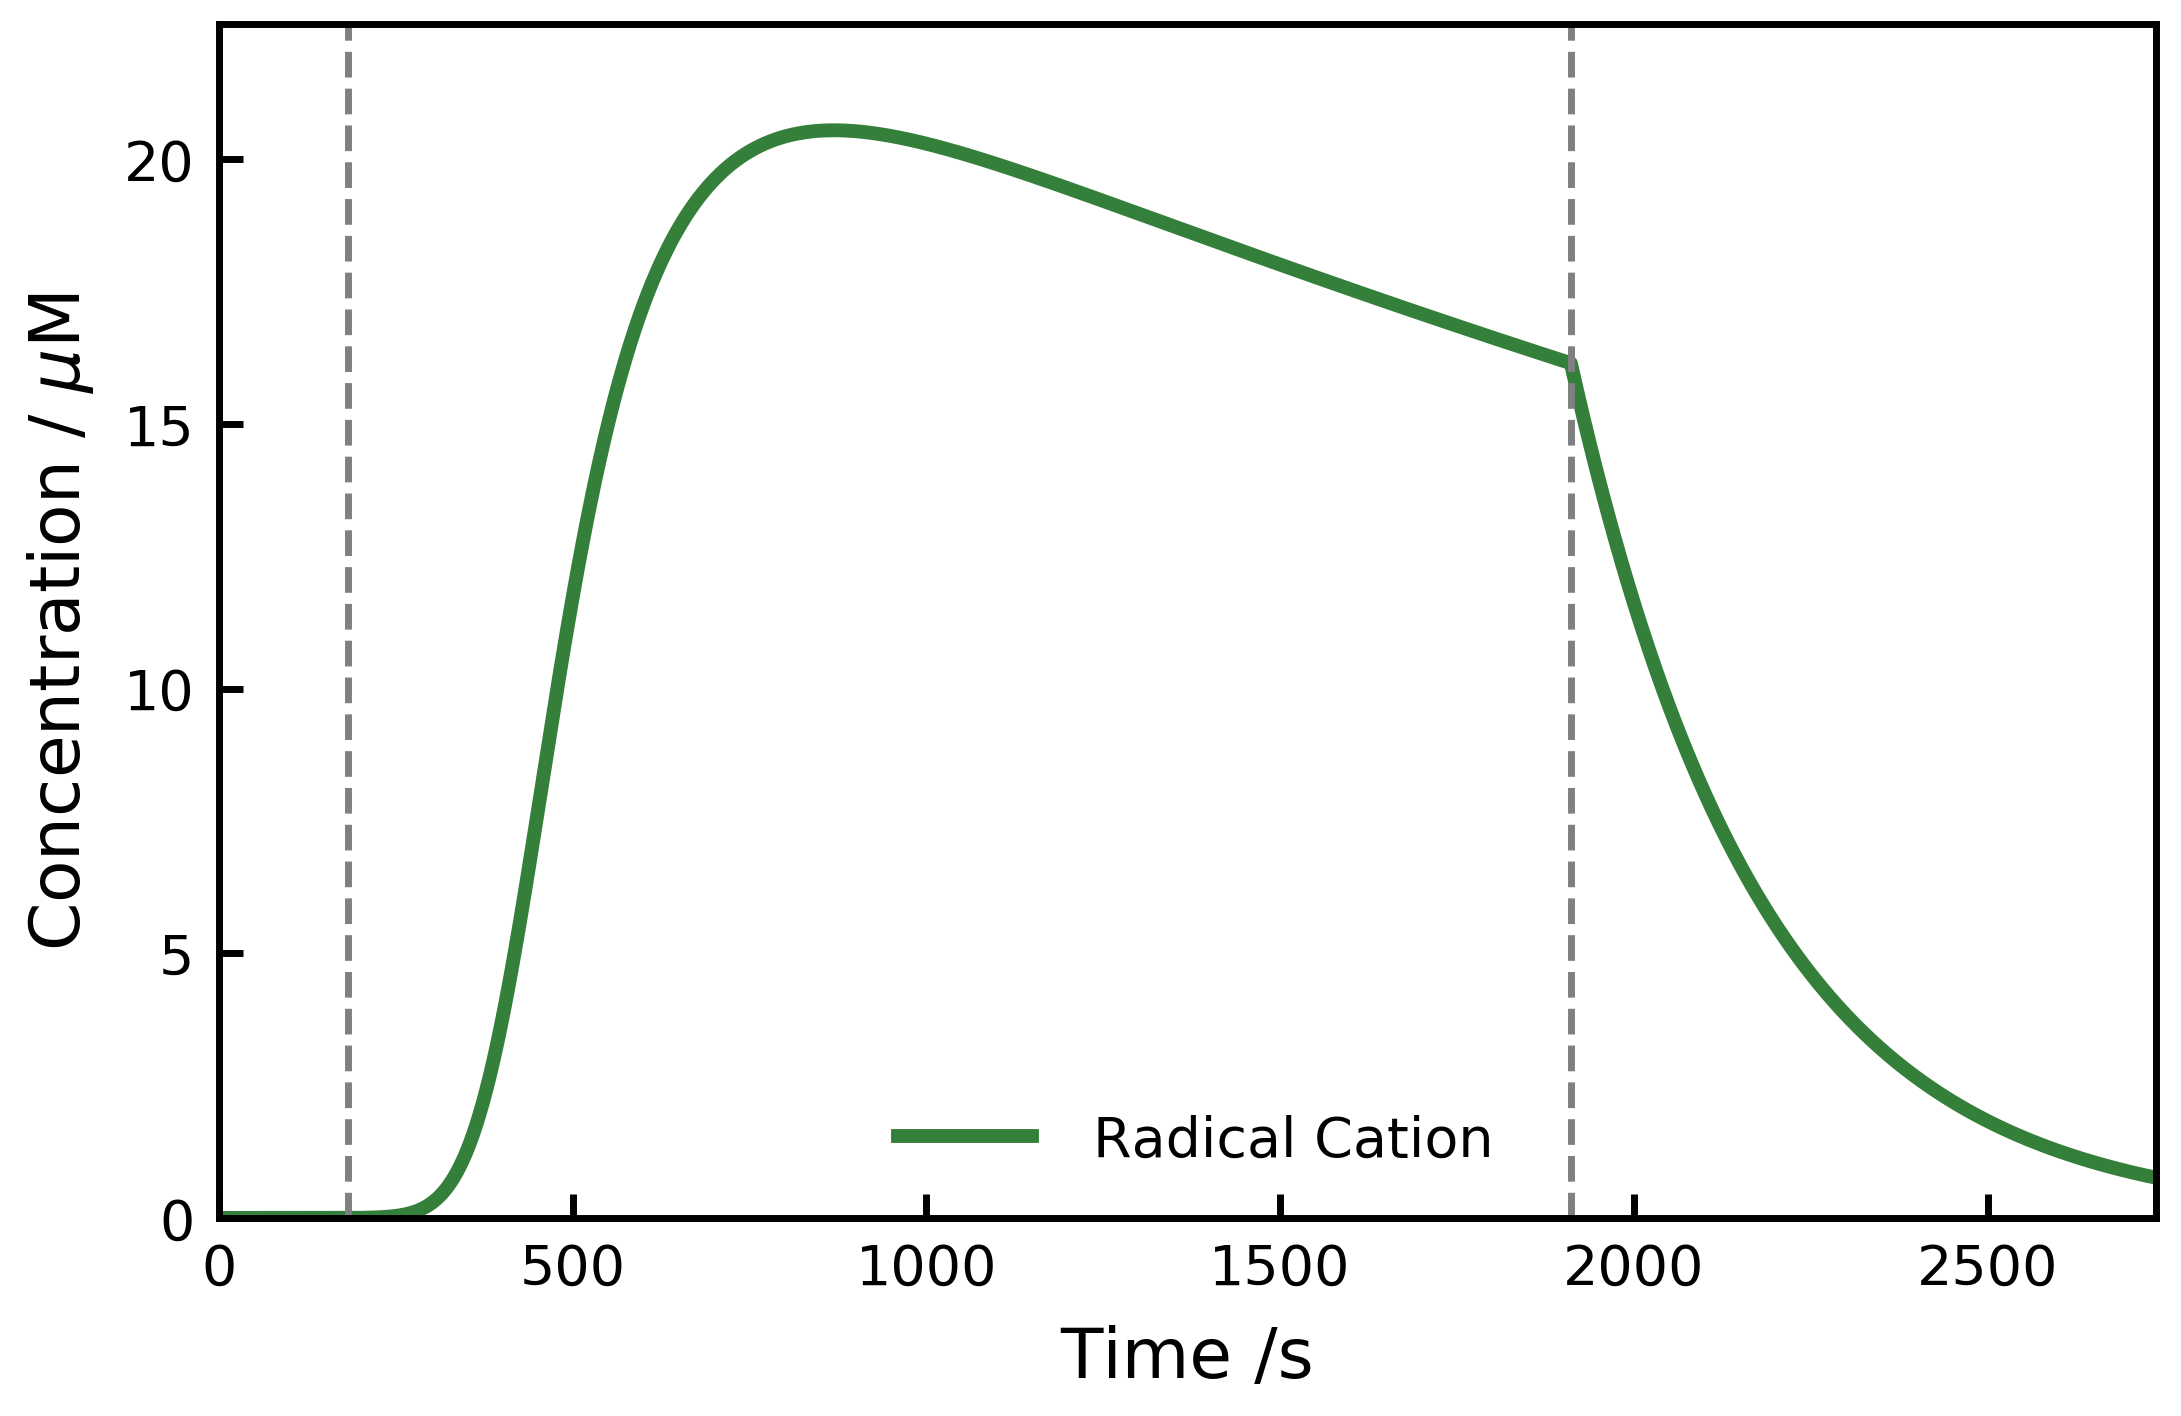

In [20]:
# define initial model parameters ahead of fitting
params = Parameters()
params.add('t_erf', value = 231, min=0, max=500) #413
params.add('kc', value = 0.01, min=1e-5, max=0.1, vary = False) # raises NaN if value > 0.1
params.add('kbr', value = 0.000457, min=0.0001, max=0.1) #0.000457
params.add('k', value = 0.00980, min=0.0001, max=0.1) #0.00980
params.add('kr', value = 0.00369, min=0.0001, max=0.1) #0.00369
params.add('o', value = 68, min=10, max=100) #68
params.add('c0', value = 40, vary = False)
params.add('K', value = 0.786, vary = False) 
params.add('end', value = 9000, vary = False)

# create the model and plot
model=c1.create_model(params)
of.plot_model(c1)

Elapsed time for fitting: 10.285845600000016 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 3396
    # variables        = 5
    chi-square         = 113.010792
    reduced chi-square = 0.03332669
    Akaike info crit   = -11546.1473
    Bayesian info crit = -11515.4955
[[Variables]]
    t_erf:  449.650039 +/- 0.61170152 (0.14%) (init = 231)
    kc:     0.01 (fixed)
    kbr:    3.0877e-04 +/- 9.0730e-06 (2.94%) (init = 0.000457)
    k:      0.00233643 +/- 7.1188e-06 (0.30%) (init = 0.0098)
    kr:     0.00420504 +/- 1.2098e-05 (0.29%) (init = 0.00369)
    o:      54.4501906 +/- 1.20826271 (2.22%) (init = 68)
    c0:     40 (fixed)
    K:      0.786 (fixed)
    end:    9000 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(t_erf, k)   =  0.733
    C(kbr, k)     =  0.628
    C(kbr, kr)    = -0.563
    C(t_erf, kbr) =  0.537
    C(t_erf, o)   =  0.456
    C(k, o)       =  0.448
    C(kbr, o)     =  0.338
    C(k

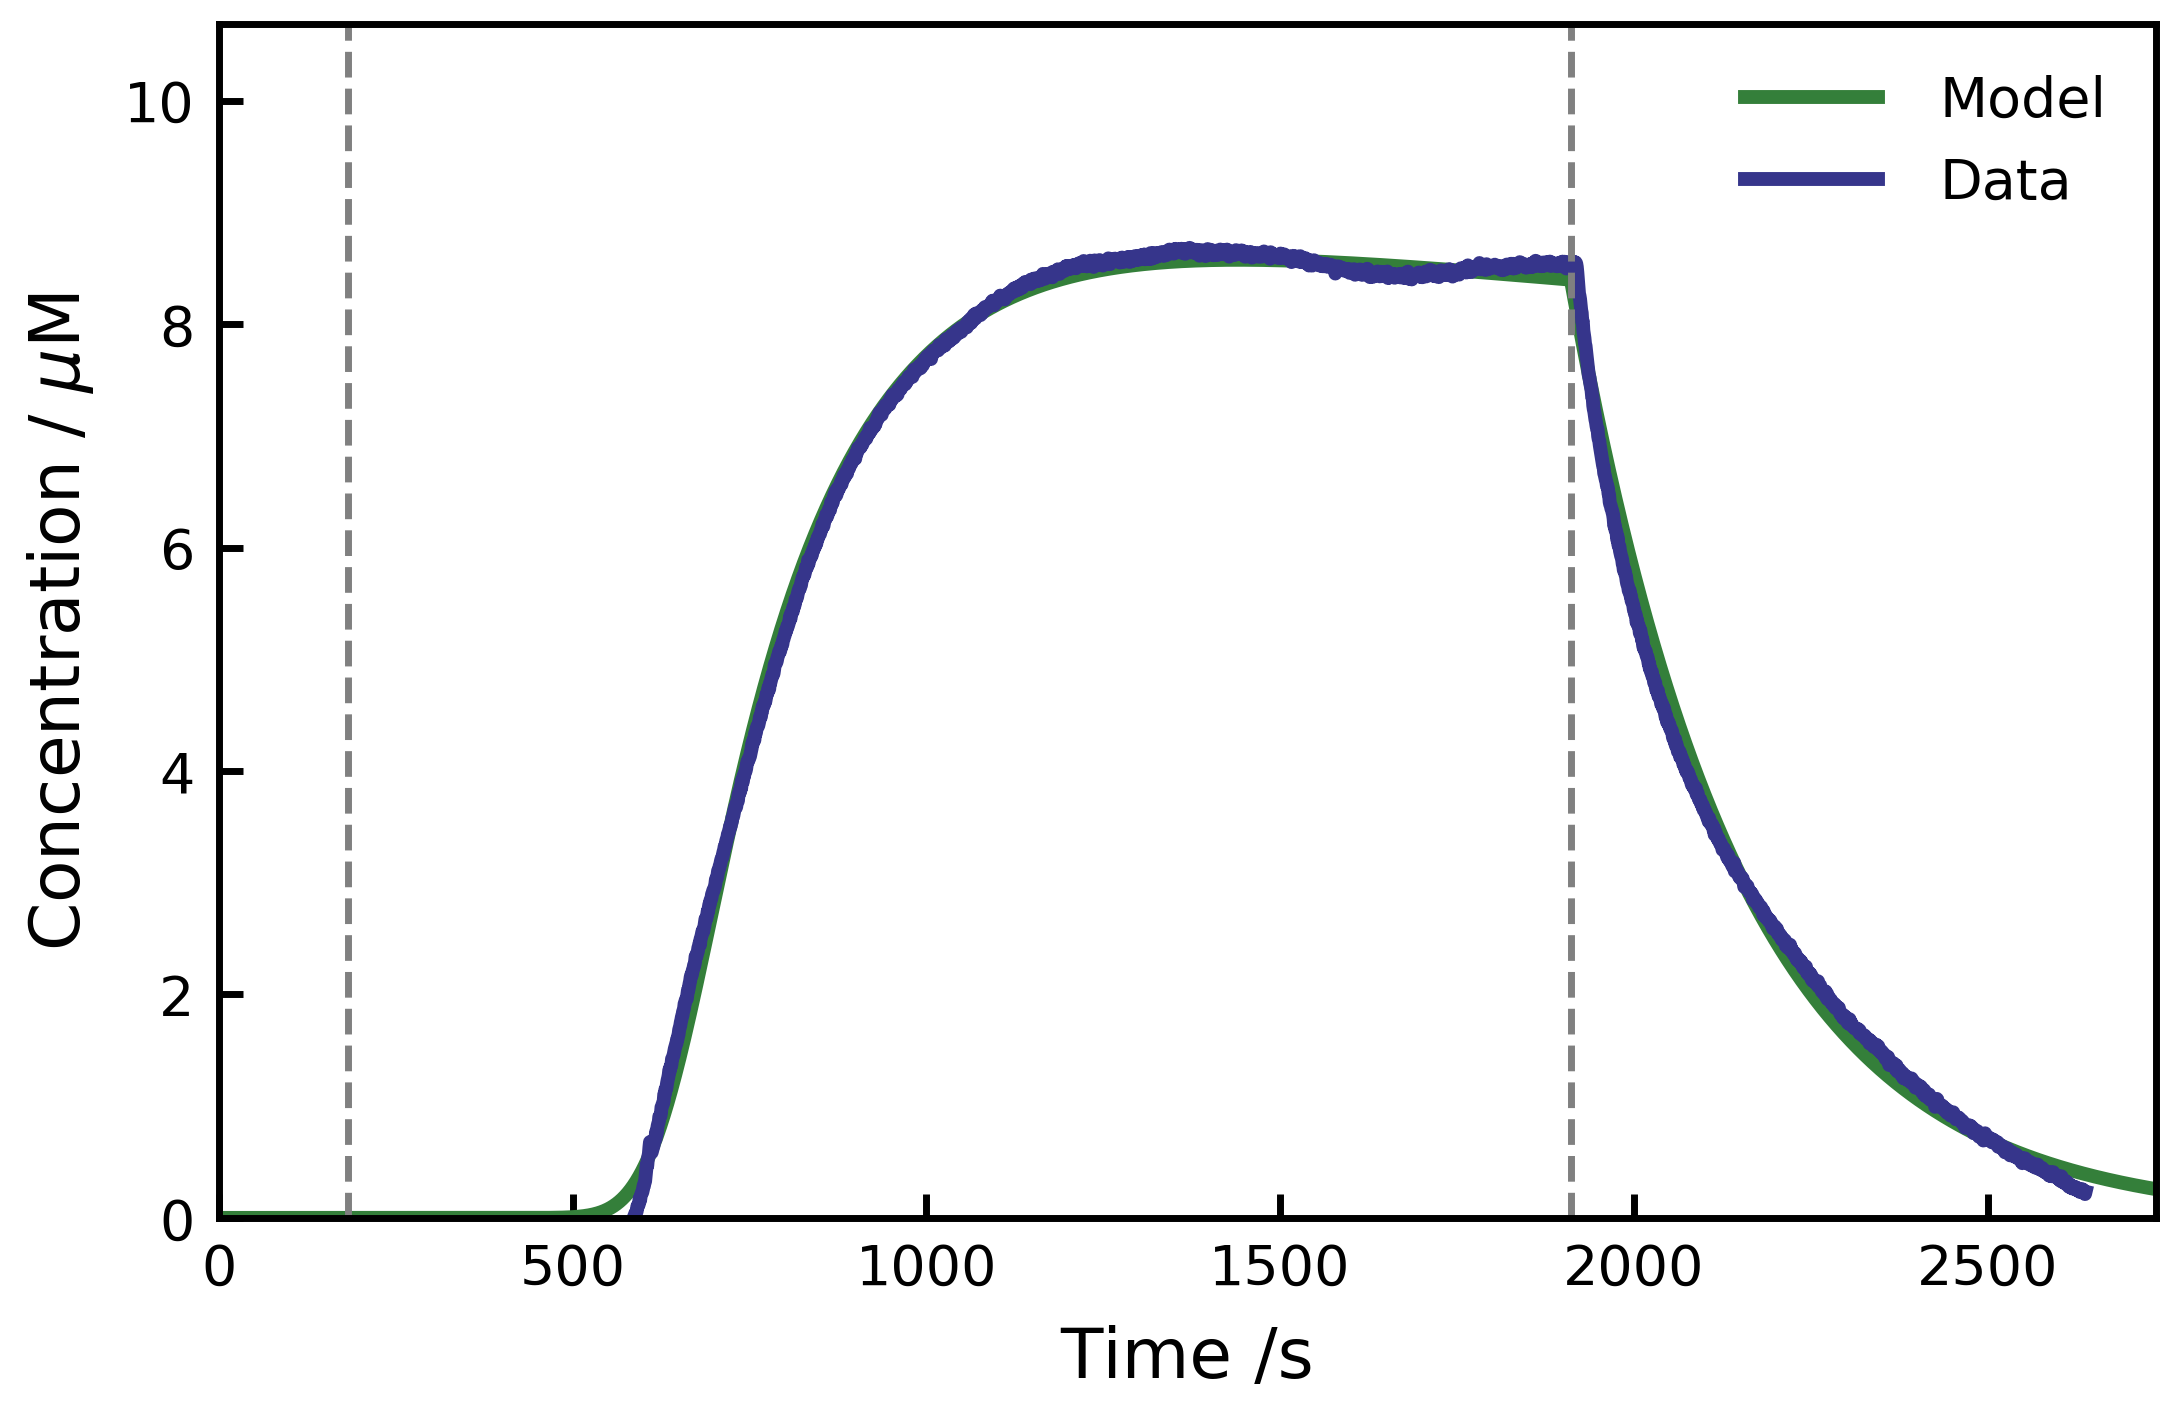

In [21]:
# Run fitting algorithm (see lmfit documentation)
c1.fit_model(params,meth='leastsq')

# Plot a comparison of the experimental data to the model
of.compare_model(c1)

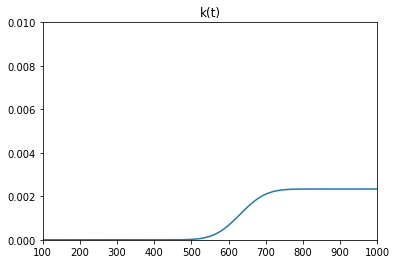

In [22]:
rates = c1.get_rates()
plt.plot(rates['k(t)'])
plt.title('k(t)')
plt.xlim(100,1000);
plt.ylim(0,0.01);

In [23]:
# Export fitted model to csv file
c1.model2csv('2019-11-06-alt-2-model.csv',export_path)

Model data saved to .csv succesfully. 

